In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Lambda


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
BATCH_SIZE = 64

## Data preparation

In [5]:
train_data =datasets.MNIST(root='data',train=True, download = True,transform=transforms.ToTensor()) #,target_transform =transforms.Compose([lambda y: torch.zeros(10,dtype=torch.float).scatter_(0,torch.tensor(y), value=1)]))
test_data = datasets.MNIST(root='data', train= False, download = True, transform=transforms.ToTensor())




train_subset, val_subset = torch.utils.data.random_split(train_data, [50000, 10000], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_data, shuffle=False, batch_size=BATCH_SIZE)

100%|██████████| 9912422/9912422 [00:00<00:00, 109629891.71it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 85668807.51it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29272127.54it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1071578.85it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [64]:
def one_hot_encode(labels, num_classes):
    y = torch.zeros(labels.shape[0], num_classes)
    y[torch.arange(labels.shape[0]), labels] = 1
    return y


In [6]:
#Vanilla RNN

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.input_size = input_size
        self.rnn = nn.RNN(input_size = self.input_size, hidden_size= self.hidden_size, num_layers = self.num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * 28, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # print('======sieze of xo===', x.size(0))
        # x=x.permute(1,0,2)

        # Forward propagate LSTM
        out, _ = self.rnn(x,h0)
        # out = out.reshape
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        # out = F.log_softmax(out, dim = 1)
        return F.log_softmax(out) #out



In [7]:
# Recurrent neural network with GRU (many-to-one)
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * 28, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)
        # out = out.view(-1, self.hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        out = F.log_softmax(out, dim = 1)
        return out

In [8]:
#Recurrent neural network with LSTM
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * 28, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(
            x, (h0, c0)
        )  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return F.log_softmax(out)


In [45]:
#Bidirectional RNN
class RNN_Bidirectional(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_Bidirectional, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional = True)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        # h0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
        # c0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.rnn(x,(h0,c0))
              # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out = out.reshape(out.shape[0], -1)
        # print(out.shape)
        out = self.fc(out[:, -1, :])
        # print('outshape', out.shape)

        # Decode the hidden state of the last time step
        # out = self.fc(out)
        return F.log_softmax(out)


In [10]:
#Hyperparameters

input_size = 28
hidden_size = 128
num_layers = 1
num_classes = 10
sequence_length = 28
learning_rate = 0.005
batch_size = 64
num_epochs = 5


model = RNN(input_size, hidden_size, num_layers, num_classes ).to(device)

### Training

In [16]:
def best_fit( model = model, epochs = 2, learning_rate = 0.001,input_size = 28, hidden_size = 128,num_layers= 2, num_classes = 10, model_name='rnn.ckpt'):  #X_train, y_train_one_hot, learning_rate = 0.001, activation_f = 'sigmoid', init_mode = 'xavier',

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    train_cost, test_cost, accuracy, iterations = [],[],[],[]
    count=0

    for epoch in range(epochs):
      model.train()
      for i, (images,labels) in enumerate(train_loader):
        #get the data from cuda
        images = images.to(device)
        labels = labels.to(device)
        # print("=====size o image=====", images.shape)
        images = images.view(-1,28,28)
        # print('===new size==', images.shape)

        optimizer.zero_grad()

        #forward
        outputs = model(images)

        loss = criterion(outputs, labels)

        #backward
        loss.backward()

        #gradient descent or adam step
        optimizer.step()

        # count+=1

        if i%200 ==0 :
          model.eval()

          test_loss = 0
          num_correct = 0
          num_samples = 0



          with torch.no_grad():
            for images, labels in val_loader:
              images = images.to(device)
              labels = labels.to(device)
              images = images.view(-1,28,28)

              preds = model(images)
              test_loss += criterion(preds,labels).item()

              _,predictions = torch.max(preds.data,1)
              # print('predictions',predictions.shape)
              # print('labels',labels.shape)
              # print(predictions.shape)
              # print(labels.shape)
              num_correct += (predictions == labels).sum()
              num_samples += predictions.size(0)

            # train_cost.append(loss.item())
            # accuracy.append(float(num_correct)/ num_samples)
            # test_cost.append(test_loss)


          test_loss /=len(test_loader)
          test_acc = float(num_correct)/ num_samples

          print('Epoch[{}/{}], Train loss: {:.4f}, Test loss: {:.4f}, Test Acc: {:.2f}%'
          .format(epoch+1, epochs, loss.item(), test_loss, test_acc*100))

          # print('iteration:{}, Train loss: {:.4f}, Test loss: {:.4f}, Test Acc: {:.2f}%'
          # .format(count, loss.item(), test_loss, test_acc*100))

          train_cost.append(loss.item())
          accuracy.append(float(num_correct)/ num_samples)
          test_cost.append(test_loss)
          # iterations.append(count)

    #Plot the training cost curve
    plt.plot(200*np.arange(len(train_cost)), train_cost, 'r', label="Training loss")
    plt.plot(200*np.arange(len(train_cost)), test_cost, label='Validation loss') #list(range(len(train_cost)))

    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(' Training and Validation Plot')
    plt.grid()
    plt.legend()
    plt.show()

    x = 200*np.arange(len(accuracy))
    # plt.figure(figsize=(18,9))
    plt.plot(x,accuracy,label ='Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Prediction Plot')
    plt.legend()
    plt.grid()
    plt.show()

    print('Average accuracy', sum(accuracy)/len(accuracy))

    #saving the model
    torch.save(model.state_dict(), model_name)

    return None


### Evaluating the Model

In [12]:
def evaluate(model, iterator, criterion):

    test_loss = 0
    num_correct = 0
    num_samples = 0

    model.eval()

    with torch.no_grad():

        for i,(images,labels) in enumerate(iterator):

            images = images.to(device)
            labels = labels.to(device)
            images = images.view(-1,28,28)

            # output = model(images)
            preds = model(images)
            test_loss += criterion(preds,labels).item()
            _,predictions = torch.max(preds.data,1)
            num_correct += (predictions == labels).sum()
            num_samples += predictions.size(0)

    return test_loss / len(iterator), float(num_correct)/ num_samples

### Trainig Vanilla RNN

<ipython-input-6-6a8707db0112>:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out) #out


Epoch[1/5], Train loss: 2.2925, Test loss: 2.5797, Test Acc: 11.32%
Epoch[1/5], Train loss: 0.3707, Test loss: 0.3511, Test Acc: 88.78%
Epoch[1/5], Train loss: 0.1797, Test loss: 0.2669, Test Acc: 92.27%
Epoch[1/5], Train loss: 0.3405, Test loss: 0.2627, Test Acc: 92.06%
Epoch[2/5], Train loss: 0.4045, Test loss: 0.3587, Test Acc: 89.75%
Epoch[2/5], Train loss: 0.6517, Test loss: 0.5599, Test Acc: 85.43%
Epoch[2/5], Train loss: 0.4010, Test loss: 0.4035, Test Acc: 89.04%
Epoch[2/5], Train loss: 0.7163, Test loss: 0.4588, Test Acc: 88.70%
Epoch[3/5], Train loss: 0.6366, Test loss: 0.5736, Test Acc: 86.36%
Epoch[3/5], Train loss: 0.5787, Test loss: 0.3844, Test Acc: 90.31%
Epoch[3/5], Train loss: 0.2600, Test loss: 0.3965, Test Acc: 90.31%
Epoch[3/5], Train loss: 1.3743, Test loss: 0.8723, Test Acc: 83.29%
Epoch[4/5], Train loss: 0.2830, Test loss: 0.5541, Test Acc: 88.79%
Epoch[4/5], Train loss: 0.3809, Test loss: 0.6458, Test Acc: 87.99%
Epoch[4/5], Train loss: 0.1904, Test loss: 0.527

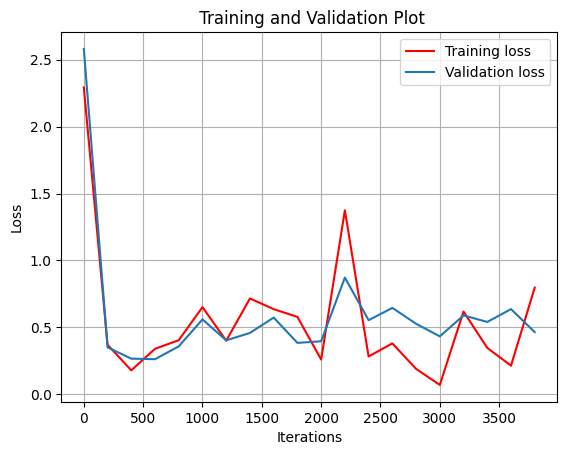

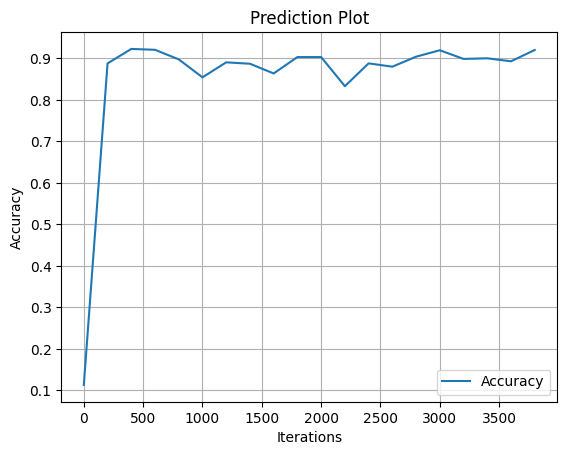

Average accuracy 0.85396


In [13]:
#Vanilla RNN
epoch_cost = best_fit(model = model, input_size= input_size, hidden_size= hidden_size, num_layers = num_layers, num_classes= num_classes,epochs= num_epochs,learning_rate = learning_rate,model_name='rnn.ckpt')

### Testing Vanilla RNN

In [14]:
#testing vanilla rnn model
model.load_state_dict(torch.load('rnn.ckpt'))
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

<ipython-input-6-6a8707db0112>:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out) #out


	Test Loss: 0.702 | Test Acc: 86.83%



### Test Accuracy: 86.83%

### Training RNN GRU model

Epoch[1/5], Train loss: 2.3008, Test loss: 2.2215, Test Acc: 21.19%
Epoch[1/5], Train loss: 0.0360, Test loss: 0.2078, Test Acc: 93.90%
Epoch[1/5], Train loss: 0.0717, Test loss: 0.1308, Test Acc: 96.18%
Epoch[1/5], Train loss: 0.0623, Test loss: 0.1191, Test Acc: 96.67%
Epoch[2/5], Train loss: 0.1225, Test loss: 0.0835, Test Acc: 97.59%
Epoch[2/5], Train loss: 0.0219, Test loss: 0.0930, Test Acc: 97.40%
Epoch[2/5], Train loss: 0.0072, Test loss: 0.1350, Test Acc: 96.40%
Epoch[2/5], Train loss: 0.0959, Test loss: 0.0833, Test Acc: 98.01%
Epoch[3/5], Train loss: 0.0182, Test loss: 0.1027, Test Acc: 97.35%
Epoch[3/5], Train loss: 0.0032, Test loss: 0.0689, Test Acc: 98.09%
Epoch[3/5], Train loss: 0.0542, Test loss: 0.0825, Test Acc: 97.57%
Epoch[3/5], Train loss: 0.2277, Test loss: 0.0736, Test Acc: 98.10%
Epoch[4/5], Train loss: 0.0004, Test loss: 0.0828, Test Acc: 98.12%
Epoch[4/5], Train loss: 0.2709, Test loss: 0.0930, Test Acc: 97.70%
Epoch[4/5], Train loss: 0.0105, Test loss: 0.098

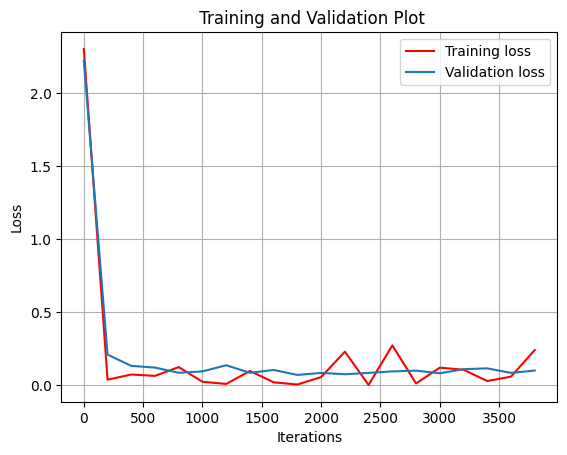

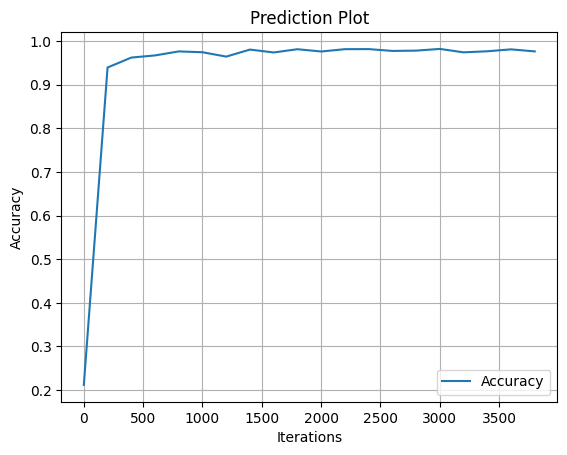

Average accuracy 0.9354249999999998


In [15]:
#Training GRU
model = RNN_GRU(input_size, hidden_size, num_layers, num_classes ).to(device)
epoch_cost = best_fit(model = model, input_size= input_size, hidden_size= hidden_size, num_layers = num_layers, num_classes= num_classes,epochs= num_epochs,learning_rate = learning_rate,model_name ='rnn_gru.ckpt')

### Testing

In [17]:
model.load_state_dict(torch.load('rnn_gru.ckpt'))
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

	Test Loss: 0.084 | Test Acc: 98.13%


### Test Accuracy : 98.13%

### Training RNN LSTM

<ipython-input-8-3c943208c92d>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Epoch[1/5], Train loss: 2.3029, Test loss: 2.2162, Test Acc: 31.84%
Epoch[1/5], Train loss: 0.2263, Test loss: 0.1936, Test Acc: 94.16%
Epoch[1/5], Train loss: 0.0909, Test loss: 0.1200, Test Acc: 96.41%
Epoch[1/5], Train loss: 0.1125, Test loss: 0.0905, Test Acc: 97.28%
Epoch[2/5], Train loss: 0.0156, Test loss: 0.0833, Test Acc: 97.69%
Epoch[2/5], Train loss: 0.1448, Test loss: 0.0749, Test Acc: 97.48%
Epoch[2/5], Train loss: 0.0419, Test loss: 0.0738, Test Acc: 97.88%
Epoch[2/5], Train loss: 0.0634, Test loss: 0.0688, Test Acc: 97.71%
Epoch[3/5], Train loss: 0.0154, Test loss: 0.0583, Test Acc: 98.25%
Epoch[3/5], Train loss: 0.0127, Test loss: 0.0593, Test Acc: 98.23%
Epoch[3/5], Train loss: 0.0048, Test loss: 0.0529, Test Acc: 98.23%
Epoch[3/5], Train loss: 0.0897, Test loss: 0.0596, Test Acc: 98.14%
Epoch[4/5], Train loss: 0.0490, Test loss: 0.0636, Test Acc: 97.98%
Epoch[4/5], Train loss: 0.0323, Test loss: 0.0589, Test Acc: 98.24%
Epoch[4/5], Train loss: 0.0106, Test loss: 0.069

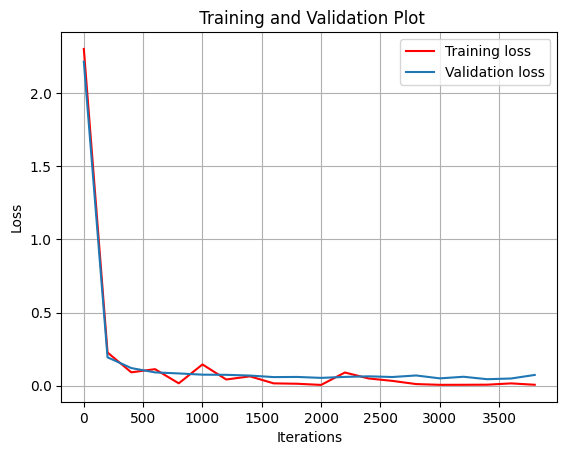

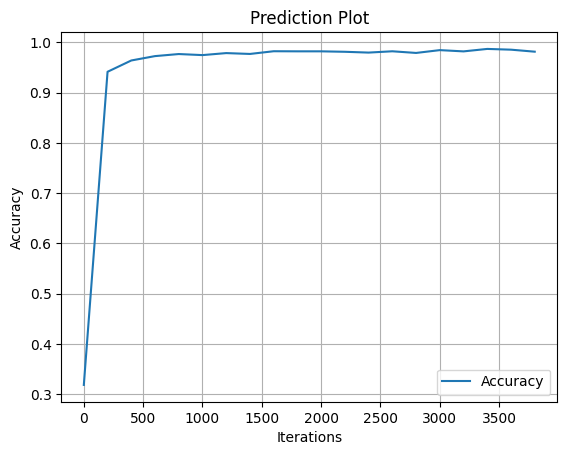

Average accuracy 0.9447750000000003


In [18]:
#training rnn_lstm
model = RNN_LSTM(input_size, hidden_size, num_layers, num_classes ).to(device)
epoch_cost = best_fit(model = model, input_size= input_size, hidden_size= hidden_size, num_layers = num_layers, num_classes= num_classes,epochs= num_epochs,learning_rate = learning_rate,model_name='rnn_lstm.ckpt')

### Testing

In [19]:
model.load_state_dict(torch.load('rnn_lstm.ckpt'))
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

<ipython-input-8-3c943208c92d>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


	Test Loss: 0.048 | Test Acc: 98.60%


### Test Accuracy of RNN LSTM : 98.60%

### Training Bidirection RNN model

<ipython-input-45-a165172e29a4>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Epoch[1/5], Train loss: 2.3069, Test loss: 2.3021, Test Acc: 9.18%
Epoch[1/5], Train loss: 0.4842, Test loss: 0.3866, Test Acc: 88.42%
Epoch[1/5], Train loss: 0.1615, Test loss: 0.1814, Test Acc: 94.92%
Epoch[1/5], Train loss: 0.1320, Test loss: 0.1790, Test Acc: 94.87%
Epoch[2/5], Train loss: 0.0394, Test loss: 0.1499, Test Acc: 95.47%
Epoch[2/5], Train loss: 0.0858, Test loss: 0.1007, Test Acc: 97.24%
Epoch[2/5], Train loss: 0.0418, Test loss: 0.0920, Test Acc: 97.31%
Epoch[2/5], Train loss: 0.1738, Test loss: 0.0837, Test Acc: 97.51%
Epoch[3/5], Train loss: 0.0732, Test loss: 0.0968, Test Acc: 97.33%
Epoch[3/5], Train loss: 0.0114, Test loss: 0.0971, Test Acc: 97.34%
Epoch[3/5], Train loss: 0.0165, Test loss: 0.0745, Test Acc: 97.74%
Epoch[3/5], Train loss: 0.1053, Test loss: 0.0875, Test Acc: 97.46%
Epoch[4/5], Train loss: 0.1275, Test loss: 0.0711, Test Acc: 98.09%
Epoch[4/5], Train loss: 0.0577, Test loss: 0.0850, Test Acc: 97.62%
Epoch[4/5], Train loss: 0.0410, Test loss: 0.0879

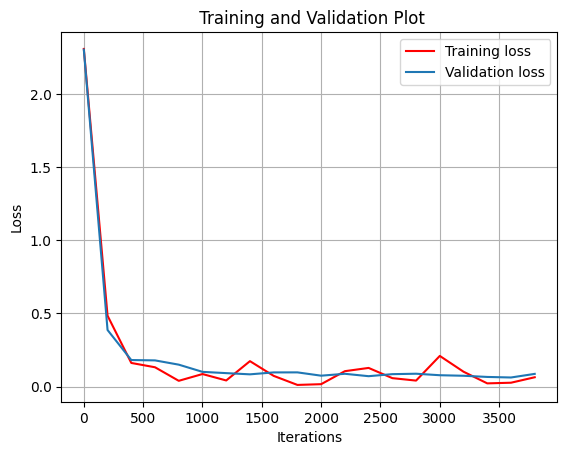

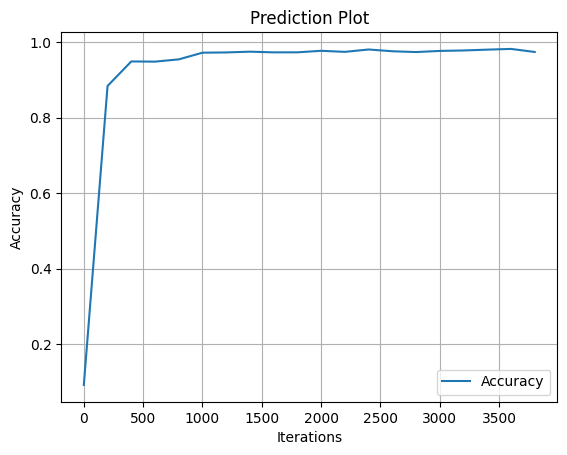

Average accuracy 0.9235849999999999


In [46]:
#training rnn bidirectional
model = RNN_Bidirectional(input_size, hidden_size, num_layers, num_classes ).to(device)
epoch_cost = best_fit(model = model, input_size= input_size, hidden_size= hidden_size, num_layers = num_layers, num_classes= num_classes,epochs= num_epochs,learning_rate = learning_rate,model_name='rnn_bidirectional.ckpt')

### Testing

In [47]:
model.load_state_dict(torch.load('rnn_bidirectional.ckpt'))
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

<ipython-input-45-a165172e29a4>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


	Test Loss: 0.066 | Test Acc: 98.26%


### Test Accuracy of bidirection rnn : 98.26%

## Testing on Custom Handwritten Dataset


In [48]:
import cv2

In [88]:
# model.load_state_dict(torch.load('rnn_bidirectional.ckpt'))
# # image = np.array(Image.open("/content/drive/MyDrive/IMG_5700.jpg"))
# image_tensor = torch.from_numpy(img_resized).float()
# print(image_tensor.shape)
# image_tensor = image_tensor.unsqueeze(0)
# output = model(image_tensor)
# predicted_output = output.argmax(-1)
# predicted_output_numpy = predicted_output.cpu().numpy()
# predicted_digit = predicted_output_numpy[0]
# print(predicted_digit)

torch.Size([28, 28])
7


<ipython-input-45-a165172e29a4>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


### Data preprocessing of handwritten digits into mnist dataset form

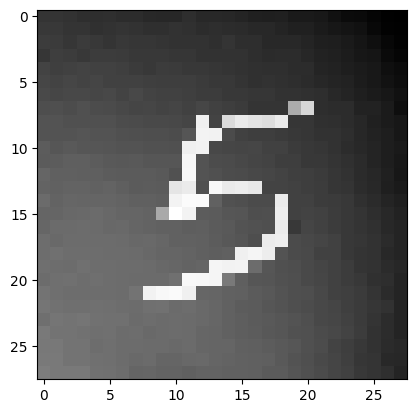

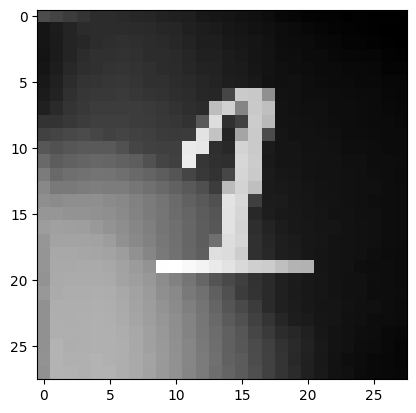

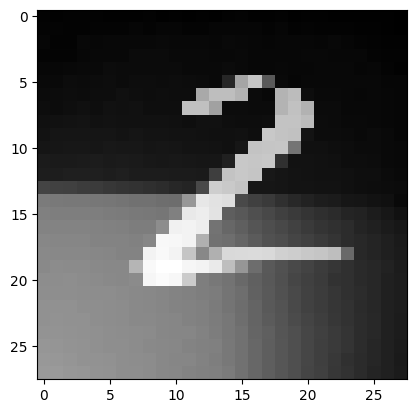

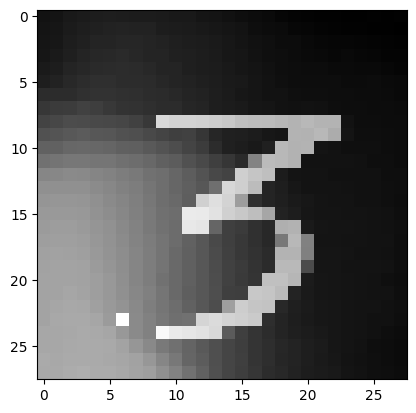

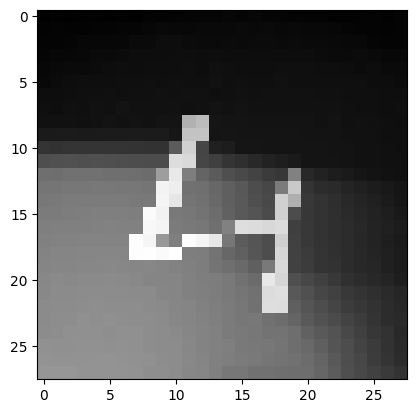

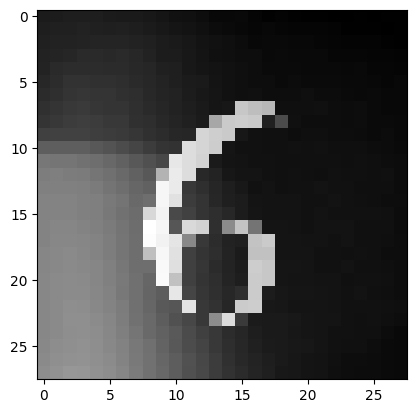

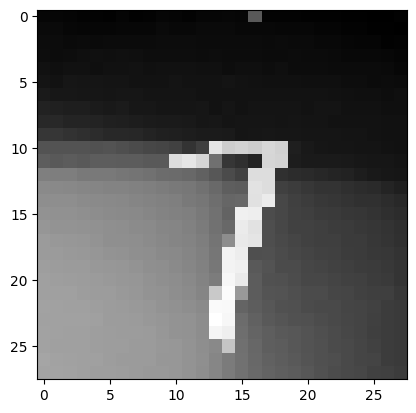

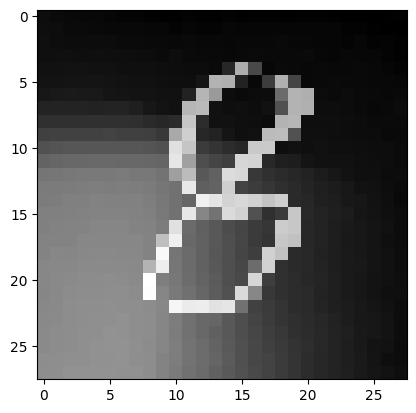

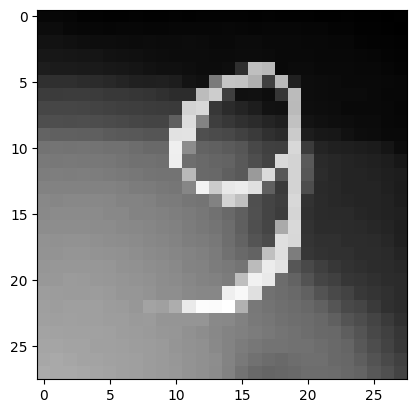

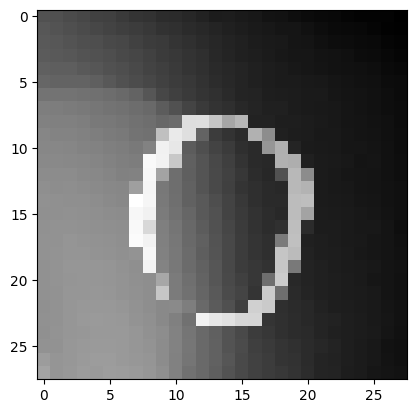

In [116]:
#making a list of path of the images
image_paths = ["/content/drive/MyDrive/IMG_5700.jpg", "/content/drive/MyDrive/IMG_5701.jpg", '/content/drive/MyDrive/IMG_5702.jpg',
               '/content/drive/MyDrive/IMG_5703.jpg','/content/drive/MyDrive/IMG_5704.jpg','/content/drive/MyDrive/IMG_5705.jpg',
               '/content/drive/MyDrive/IMG_5706.jpg','/content/drive/MyDrive/IMG_5707.jpg','/content/drive/MyDrive/IMG_5708.jpg',
               '/content/drive/MyDrive/IMG_5709.jpg']


images = []
for image_path in image_paths:
    image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    images.append(image)
new_img=[]

#resizing and bringing the handwritten images to mnist form
for img in images:
  img_resized = cv2.resize(img, (28, 28), interpolation=cv2.INTER_NEAREST)
  img_resized = cv2.bitwise_not(img_resized)
  plt.imshow(img_resized,cmap='gray')
  plt.show()
  new_img.append(img_resized)



<ipython-input-45-a165172e29a4>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


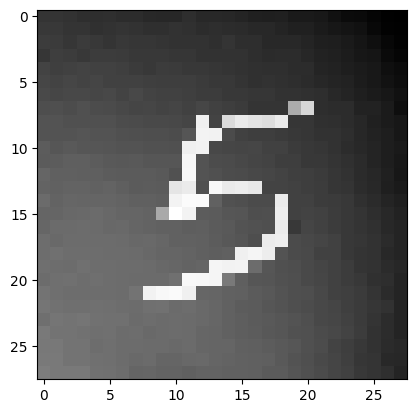

7


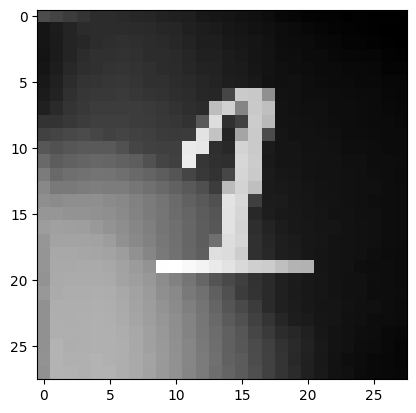

7


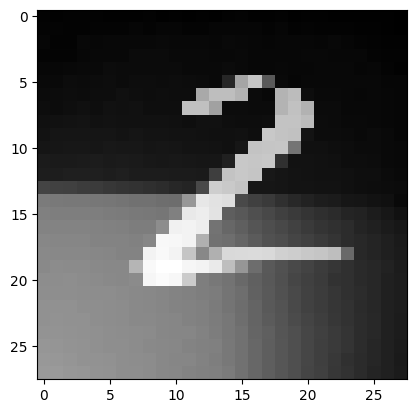

7


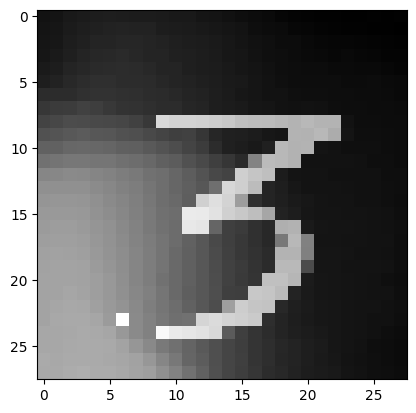

7


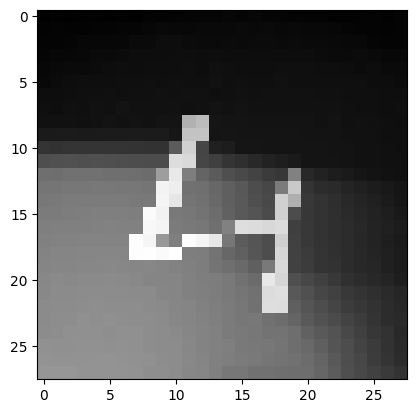

7


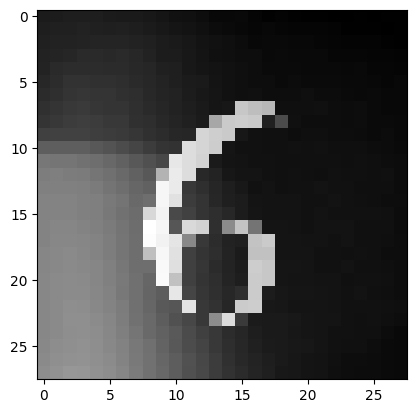

7


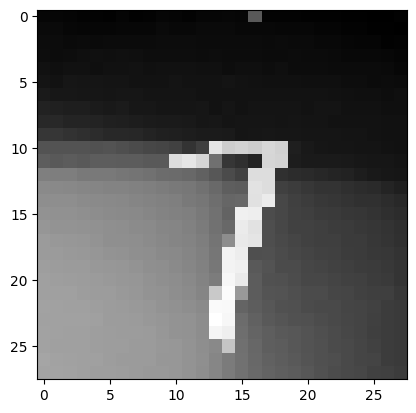

7


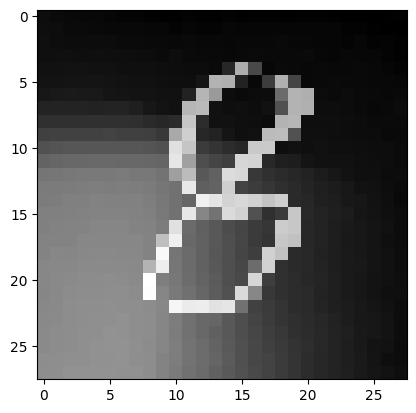

7


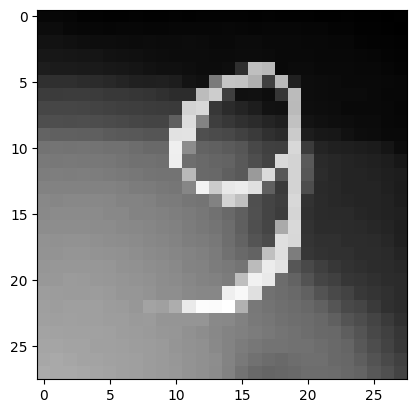

7


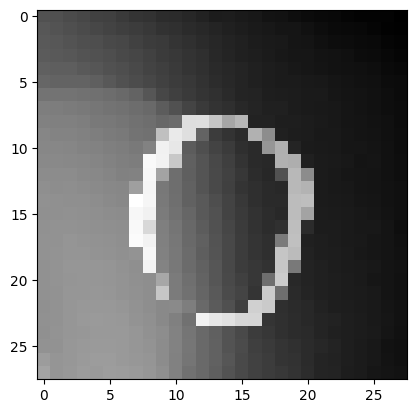

7


In [117]:
#loading the pretrained model for prediction
model.load_state_dict(torch.load('rnn_bidirectional.ckpt'))
for images in new_img:
  plt.imshow(images, cmap='gray')
  image_tensor = torch.from_numpy(images).float()
  # print(image_tensor.shape)
  image_tensor = image_tensor.unsqueeze(0)
  output = model(image_tensor)
  predicted_output = output.argmax(-1)
  predicted_output_numpy = predicted_output.cpu().numpy()
  predicted_digit = predicted_output_numpy[0]
  plt.show()

  print(predicted_digit)

### As we can see above, the model is not able to predict the custom handwritten digits. This happens because the custom dataset doesnot exactly match the mnist dataset. And therefore  model is not able to predict it correctly

### Question 2.

#### Generating dataset consisting of two binary digits and its addition

In [61]:
def getSample(stringLength, testFlag):
  #takes stringlength as input
  #returns a sample for the network - an input sequence - x and its target -y
  #x is a T*2 array, T is the length of the string and 2 since we take one bit each from each string
  #testFlag if set prints the input numbers and its sum in both decimal and binary form
  lowerBound=pow(2,stringLength-1)+1
  upperBound=pow(2,stringLength)

  num1=random.randint(lowerBound,upperBound)
  num2=random.randint(lowerBound,upperBound)

  num3=num1+num2
  num3Binary=(bin(num3)[2:])

  num1Binary=(bin(num1)[2:])

  num2Binary=(bin(num2)[2:])

  if testFlag==1:
    # pass

    print('input numbers and their sum  are', num1, ' ', num2, ' ', num3)
    print ('binary strings are', num1Binary, ' ' , num2Binary, ' ' , num3Binary)
  len_num1= (len(num1Binary))

  len_num2= (len(num2Binary))
  len_num3= (len(num3Binary))

  # since num3 will be the largest, we pad  other numbers with zeros to that num3_len
  num1Binary= ('0'*(len(num3Binary)-len(num1Binary))+num1Binary)
  num2Binary= ('0'*(len(num3Binary)-len(num2Binary))+num2Binary)


  # forming the input sequence
  # the input at first timestep is the least significant bits of the two input binary strings
  # x will be then a len_num3 ( or T ) * 2 array
  x=np.zeros((len_num3,2),dtype=np.float32)
  for i in range(0, len_num3):
    x[i,0]=num1Binary[len_num3-1-i] # note that MSB of the binray string should be the last input along the time axis
    x[i,1]=num2Binary[len_num3-1-i]
  # target vector is the sum in binary
  # convert binary string in <string> to a numpy 1D array
  #https://stackoverflow.com/questions/29091869/convert-bitstring-string-of-1-and-0s-to-numpy-array

  # y=np.array(map(int, num3Binary[::-1]))
  y = list(map(int, num3Binary[::-1]))
  y= np.array(y)
  #print (x)
  #print (y)
  return x,y

In [4]:
#rnn
class Adder(nn.Module):
  def __init__(self, inputDim, hiddenDim, outputDim):
    super(Adder, self).__init__()
    self.inputDim=inputDim
    self.hiddenDim=hiddenDim
    self.outputDim=outputDim
    self.lstm=nn.RNN(inputDim, hiddenDim )
    self.outputLayer=nn.Linear(hiddenDim, outputDim)
    self.sigmoid=nn.Sigmoid()
  def forward(self, x ):
    #size of x is T x B x featDim
    #B=1 is dummy batch dimension added, because pytorch mandates it
    #if you want B as first dimension of x then specift batchFirst=True when LSTM is initalized
    #T,D  = x.size(0), x.size(1)
    #batch is a must
    lstmOut,_ =self.lstm(x ) #x has two  dimensions  seqLen *batch* FeatDim=2
    T,B,D  = lstmOut.size(0),lstmOut.size(1) , lstmOut.size(2)
    lstmOut = lstmOut.contiguous()
        # before  feeding to linear layer we squash one dimension
    lstmOut = lstmOut.view(B*T, D)
    outputLayerActivations=self.outputLayer(lstmOut)
    #reshape actiavtions to T*B*outputlayersize
    outputLayerActivations=outputLayerActivations.view(T,B,-1).squeeze(1)
    outputSigmoid=self.sigmoid(outputLayerActivations)
    return outputSigmoid

Training

In [5]:
def training(loss_function, lstmSize,input_dim, output_dim,stringLen, model, model_name):

  # model =Adder(input_dim,lstmSize, output_dim)
  print ('model initialized')
  #optimizer = optim.SGD(model.parameters(), lr=3e-2, momentum=0.8)
  optimizer=optim.Adam(model.parameters(),lr=0.005)
  iterations=500
  min_epochs =20
  stringLen=3
  testFlag =0
  cost=[]
  ### epochs ##
  num_epochs,totalLoss= 0,float("inf")
  while num_epochs < min_epochs:

    # print(" Avg. Loss for last 500 samples = %lf"%(totalLoss))
    print('Epoch {}, Train loss:{:.4f}'.format(num_epochs+1, totalLoss))
    num_epochs +=1
    totalLoss=0

    for i in range(0,iterations): # average the loss over 200 samples

      # stringLen=4
      # testFlag=0
      x,y=getSample(stringLen, testFlag)

      model.zero_grad()


      x_var=autograd.Variable(torch.from_numpy(x).unsqueeze(1).float()) #convert to torch tensor and variable
      # unsqueeze() is used to add the extra dimension since
      # your input need to be of t*batchsize*featDim; you cant do away with the batch in pytorch
      seqLen=x_var.size(0)
      #print (x_var)
      x_var= x_var.contiguous()
      # y_var=autograd.Variable(torch.from_numpy(y).float())
      y= y.astype(np.float32)
      y_var = torch.from_numpy(y).float().requires_grad_()

      pred = model(x_var)
      #finalScores=finalScores.
      y_var = y_var.view(-1,1)

      loss=loss_function(pred,y_var)
      # totalLoss+=loss.data[0]
      totalLoss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    totalLoss=totalLoss/iterations
    cost.append(totalLoss)
  print('Training finished')
  # print(len(cost))
  # print(cost)
  # x = 200*np.arange(len(accuracy))
  # plt.figure(figsize=(18,9))
  plt.plot(np.arange(len(cost)),cost,label ='Training loss')
  plt.xlabel('epochs')
  plt.ylabel('Loss')
      # plt.plot(x,test_cost,label='test_loss')
  plt.legend()
  plt.grid()
  plt.show()
  # model_name = 'binary_rnn.pt'
  torch.save(model.state_dict(), model_name)
  # print('average accuracy', sum(accuracy)/len(accuracy))


Training the first model with mse loss with string length as 3

model initialized
Epoch 1, Train loss:inf
Epoch 2, Train loss:0.1862
Epoch 3, Train loss:0.1716
Epoch 4, Train loss:0.1379
Epoch 5, Train loss:0.0748
Epoch 6, Train loss:0.0178
Epoch 7, Train loss:0.0055
Epoch 8, Train loss:0.0028
Epoch 9, Train loss:0.0015
Epoch 10, Train loss:0.0009
Epoch 11, Train loss:0.0006
Epoch 12, Train loss:0.0004
Epoch 13, Train loss:0.0003
Epoch 14, Train loss:0.0002
Epoch 15, Train loss:0.0002
Epoch 16, Train loss:0.0001
Epoch 17, Train loss:0.0001
Epoch 18, Train loss:0.0001
Epoch 19, Train loss:0.0001
Epoch 20, Train loss:0.0000
Training finished


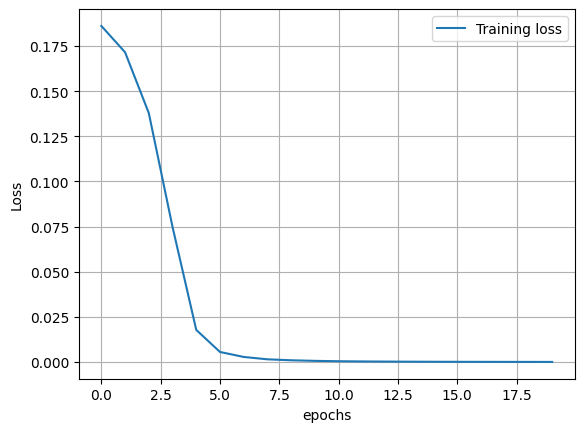

In [9]:
import torch.optim as optim

from __future__ import print_function
import numpy as np
from time import sleep
import random
import sys
import torch.autograd as autograd



LOSS_FUNCTION = nn.MSELoss()
LSTMSIZE = 10
INPUT_DIM = 2
OUTPUT_DIM = 1
STRING_LEN =3
model =Adder(INPUT_DIM,LSTMSIZE, OUTPUT_DIM)
di= training(loss_function=LOSS_FUNCTION, lstmSize =LSTMSIZE, input_dim=INPUT_DIM, output_dim= OUTPUT_DIM, stringLen= STRING_LEN, model=model, model_name='binary_rnn.pt')

Evaluation on randomly generated binary numbers

In [59]:
def evaluate(stringLen,):
  testFlag=1
  num_correct_bits=0
  total_num_bits=0
  bit_acc=[]
  cost=[]
  total_loss =0


  # test the network on 10 random binary string addition cases where stringLen=4
  for i in range (0,10):
    correct_bit=0
    c=0
    x,y=getSample(stringLen,testFlag)
    x_var=autograd.Variable(torch.from_numpy(x).unsqueeze(1).float())
    y_var=autograd.Variable(torch.from_numpy(y).float())
    seqLen=x_var.size(0)
    x_var= x_var.contiguous()
    finalScores = model(x_var) #.data.t()
    criterion = nn.MSELoss()

    loss = criterion(finalScores,y_var)
    total_loss += loss.item()

    print(finalScores.t())
    for i in finalScores:
      if i >= 0.5:
        correct_bit+=1

    # print('Bit accuracy of this  number is ', 100*(correct_bit/len(finalScores)))
    print('Bit accuracy of this  number is {:.4f}%'.format(100*(correct_bit/len(finalScores))))
    print(end='\n\n')
    bit_acc.append(correct_bit/len(finalScores))
    cost.append(loss.item())
  print('Average Accuracy ', 100*(sum(bit_acc)/10))
  print('LOSS : ', cost)

  # plt.plot(np.arange(10), bit_acc)
  # plt.show()

  plt.plot(np.arange(10), cost,label='Test Loss ')
  plt.xlabel('Different numbers')
  plt.ylabel('Loss for each binary number')
  plt.legend()
  plt.grid()
  plt.show()

Testing the model for string length 5

input numbers and their sum  are 18   28   46
binary strings are 10010   11100   101110
tensor([[0.0069, 0.9942, 0.9974, 0.9978, 0.0658, 0.9994]],
       grad_fn=<TBackward0>)
Bit accuracy of this  number is 66.6667%


input numbers and their sum  are 22   25   47
binary strings are 10110   11001   101111
tensor([[0.9944, 0.9916, 0.9909, 0.9970, 0.0110, 1.0000]],
       grad_fn=<TBackward0>)
Bit accuracy of this  number is 83.3333%


input numbers and their sum  are 18   30   48
binary strings are 10010   11110   110000
tensor([[0.0069, 0.0066, 0.2922, 0.9666, 0.9915, 1.0000]],
       grad_fn=<TBackward0>)
Bit accuracy of this  number is 50.0000%


input numbers and their sum  are 29   22   51
binary strings are 11101   10110   110011
tensor([[0.9933, 0.9935, 0.0059, 0.9894, 0.9981, 1.0000]],
       grad_fn=<TBackward0>)
Bit accuracy of this  number is 83.3333%


input numbers and their sum  are 24   30   54
binary strings are 11000   11110   110110
tensor([[0.0069, 0.9941, 0.9977, 0.0

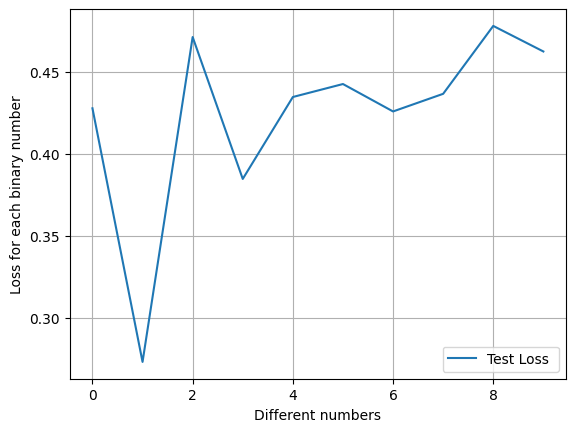

In [19]:
model.load_state_dict(torch.load('binary_rnn.pt'))
string_length=5

bit_accuracy = evaluate(stringLen=string_length,)

Testing the model for string length of 10

input numbers and their sum  are 924   971   1895
binary strings are 1110011100   1111001011   11101100111
tensor([[0.9944, 0.9910, 0.9975, 0.0749, 0.9569, 1.0000, 0.9977, 0.0731, 0.9987,
         0.9978, 1.0000]], grad_fn=<TBackward0>)
Bit accuracy of this  number is 81.8182%


input numbers and their sum  are 977   634   1611
binary strings are 1111010001   1001111010   11001001011
tensor([[0.9933, 0.9935, 0.3018, 0.9963, 0.2414, 0.9218, 0.9980, 0.9748, 0.9857,
         0.9908, 1.0000]], grad_fn=<TBackward0>)
Bit accuracy of this  number is 81.8182%


input numbers and their sum  are 934   671   1605
binary strings are 1110100110   1010011111   11001000101
tensor([[0.9944, 0.0093, 0.9989, 0.9666, 0.9546, 0.9809, 1.0000, 0.0353, 0.9734,
         0.9981, 1.0000]], grad_fn=<TBackward0>)
Bit accuracy of this  number is 81.8182%


input numbers and their sum  are 934   861   1795
binary strings are 1110100110   1101011101   11100000011
tensor([[0.9944, 0.9916, 0.0047, 0.8717, 0.9053, 0.96

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


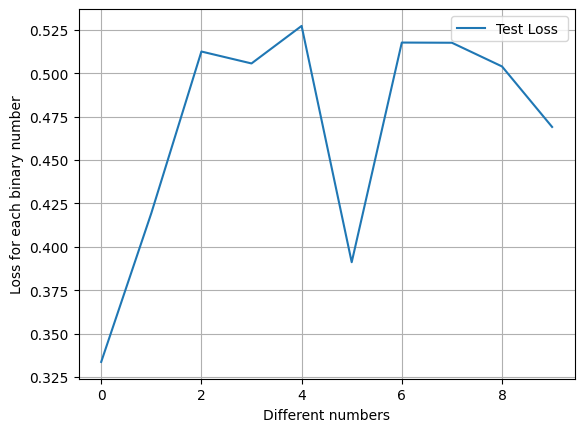

In [20]:
model.load_state_dict(torch.load('binary_rnn.pt'))
string_length=10

bit_accuracy = evaluate(stringLen=string_length,)

In [58]:

# function to generate bit accuracies for different length of strings
def evaluate_new():
  testFlag=1
  num_correct_bits=0
  total_num_bits=0
  bit_acc=[]
  cost=[]
  total_loss =0
  len_bit_acc=[]


  # test the network on 10 random binary string addition cases where stringLen=4

  for stringLen in range(1,21,1):

    for i in range (1,102):
      correct_bit=0
      c=0
      x,y=getSample(stringLen,testFlag)
      x_var=autograd.Variable(torch.from_numpy(x).unsqueeze(1).float())
      y_var=autograd.Variable(torch.from_numpy(y).float())
      seqLen=x_var.size(0)
      x_var= x_var.contiguous()
      finalScores = model(x_var) #.data.t()
      criterion = nn.MSELoss()

      loss = criterion(finalScores,y_var)
      total_loss += loss.item()

      # print(finalScores.t())
      for i in finalScores:
        if i >= 0.5:
          correct_bit+=1

      # print('Bit accuracy of this  number is ', 100*(correct_bit/len(finalScores)))
      acc=100*(correct_bit/len(finalScores))
      # print('Bit accuracy of this  number is {:.4f}%'.format(100*(correct_bit/len(finalScores))))
      # print(end='\n\n')
      bit_acc.append(correct_bit/len(finalScores))
      cost.append(loss.item())

    len_bit_acc.append(acc)
  print('Bit Accuracy for different lengths ', len_bit_acc)
  # print(len)
  # print('LOSS : ', cost)

  # plt.plot(np.arange(10), bit_acc)
  # plt.show()
  x= list(range(1,21))
  plt.plot(x, len_bit_acc,label='Bit Accuracy ') #np.arange(len(len_bit_acc))
  plt.xlabel('length of string')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid()
  plt.show()

Bit accuarcy for strings of different lengths.

Bit Accuracy for different lengths  [33.33333333333333, 66.66666666666666, 75.0, 40.0, 50.0, 71.42857142857143, 87.5, 88.88888888888889, 80.0, 81.81818181818183, 66.66666666666666, 76.92307692307693, 85.71428571428571, 73.33333333333333, 87.5, 76.47058823529412, 83.33333333333334, 84.21052631578947, 75.0, 90.47619047619048]


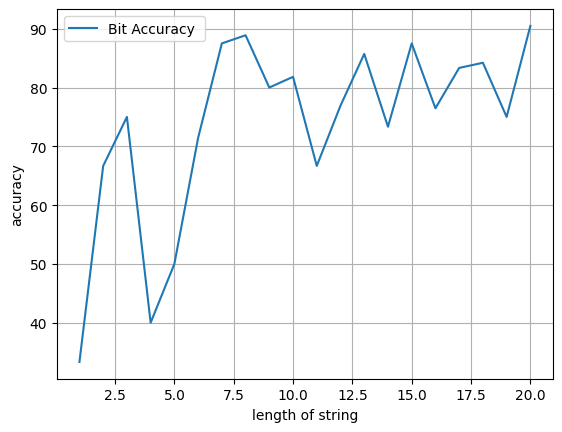

In [54]:
evaluate_new()

model initialized
Epoch 1, Train loss:inf
Epoch 2, Train loss:0.0000
Epoch 3, Train loss:0.0000
Epoch 4, Train loss:0.0000
Epoch 5, Train loss:0.0000
Epoch 6, Train loss:0.0000
Epoch 7, Train loss:0.0000
Epoch 8, Train loss:0.0000
Epoch 9, Train loss:0.0000
Epoch 10, Train loss:0.0000
Epoch 11, Train loss:0.0000
Epoch 12, Train loss:0.0000
Epoch 13, Train loss:0.0000
Epoch 14, Train loss:0.0000
Epoch 15, Train loss:0.0000
Epoch 16, Train loss:0.0000
Epoch 17, Train loss:0.0000
Epoch 18, Train loss:0.0000
Epoch 19, Train loss:0.0000
Epoch 20, Train loss:0.0000
Training finished


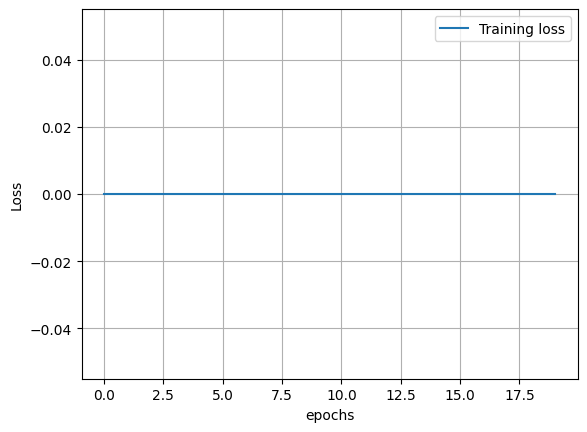

In [55]:
#changing the loss function
LOSS_FUNCTION = nn.CrossEntropyLoss()

di= training(loss_function=LOSS_FUNCTION, lstmSize =LSTMSIZE, input_dim=INPUT_DIM, output_dim= OUTPUT_DIM, stringLen= STRING_LEN, model=model, model_name = 'binary_w_crossentropy.pt')

 I am getting loss as zero fro crossentropy which seems to be wrong. The code is working for mse loss but there's some difficulty in working with cross entropy.

input numbers and their sum  are 19   20   39
binary strings are 10011   10100   100111
tensor([[9.9999e-01, 9.9999e-01, 1.0000e+00, 1.8298e-04, 8.8526e-05, 1.0000e+00]],
       grad_fn=<TBackward0>)
Bit accuracy of this  number is 66.6667%


input numbers and their sum  are 25   24   49
binary strings are 11001   11000   110001
tensor([[9.9999e-01, 5.2948e-06, 1.0555e-04, 8.3119e-05, 1.0000e+00, 1.0000e+00]],
       grad_fn=<TBackward0>)
Bit accuracy of this  number is 50.0000%


input numbers and their sum  are 24   21   45
binary strings are 11000   10101   101101
tensor([[9.9999e-01, 5.2496e-06, 1.0000e+00, 1.0000e+00, 8.9991e-06, 1.0000e+00]],
       grad_fn=<TBackward0>)
Bit accuracy of this  number is 66.6667%


input numbers and their sum  are 29   21   50
binary strings are 11101   10101   110010
tensor([[6.2747e-06, 9.9999e-01, 2.5901e-06, 9.3501e-01, 1.0000e+00, 1.0000e+00]],
       grad_fn=<TBackward0>)
Bit accuracy of this  number is 66.6667%


input numbers and their sum 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


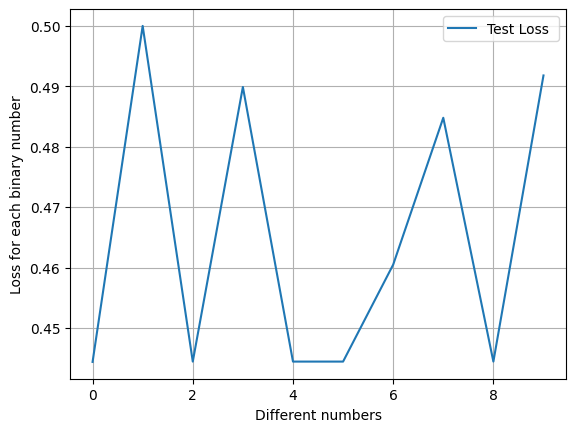

In [63]:
model.load_state_dict(torch.load('binary_w_crossentropy.pt'))
string_length=5

bit_accuracy = evaluate(stringLen=string_length,)


I am getting loss as zero fro crossentropy which seems to be wrong. The code is working for mse loss but there's some difficulty in working with cross entropy. BUt while evauating the saved model with crossentropy loss, the answers are actually correct for binary addition meaning the model is correctly learning to add binary strings